# SQL and Pandas fun using rdkit generated structures

This notebook is inspired by the work of Elholm et al. (2022) DOI: 10.1039/d2cp03032b from the group of Kasper Moth-Poulsen working on molecular solar thermal energy storage. Here, the python packages smilescombine, rdkit and ase are used for chemical calculations.
The code for python to sql conversions is based on the tutorial by Craig Dickson and uses a MySQL Server.

More Scientific Background: doi: 10.1021/acs.jcim.1c00256. Epub 2021 Jun 23
NOTE: this is my first try with jupyter/mySQL - I commented many errors out as they could be usefull to me in the future. It is a very simply database I created - the layout can be seen here:

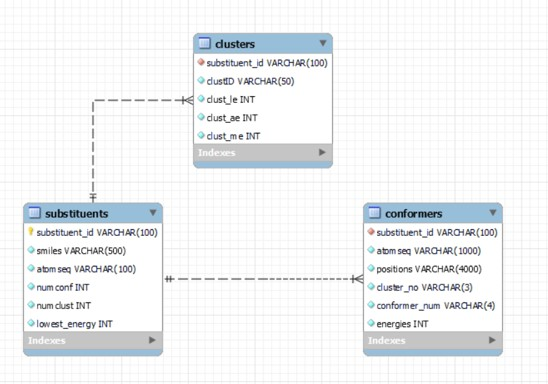

## Table of contents:

[1. Installation of required packages](#1.-Installation-of-required-packages)

[2. Let's start with defining the SQL/Python commands and connection](#2.-Let's-start-with-defining-the-SQL/Python-commands-and-connection)

[3. Let's create the SQL library](#3.-Let's-create-the-SQL-library)

[4. Define commands how to populate the table](#4.-Define-commands-how-to-populate-the-table)

[5. Let's start with the actual Chemistry in rdkit](#5.-Let's-start-with-the-actual-Chemistry-in-rdkit)

[6. Now do the clustering in rdkit](#6.-Now-do-the-clustering-in-rdkit)

[7. And, now, the rdkit results need to be uploaded and cleaned](#7.-And,-now,-the-rdkit-results-need-to-be-uploaded-and-cleaned)

[8. Switch to ase chemistry for energy computation](#8.-Switch-to-ase-chemistry-for-energy-computation)

[9. Find min and average energy conformers in SQL and populate cluster table](#9.-Find-min-and-average-energy-conformers-in-SQL-and-populate-cluster-table)


##

## 1. Installation of required packages

In [ ]:
### installation of chemical libraries:
# for rdkit see: https://www.rdkit.org/docs/GettingStartedInPython.html
# for ase  see: https://wiki.fysik.dtu.dk/ase/index.html
# further inspirations: https://peterschindler.github.io/


#! conda update -n base -c defaults conda
#! conda create -n rdkit -y
! conda activate rdkit 
#! conda install -c conda-forge rdkit -y 


#! pip install scipy --upgrade --user
#! pip install --user smilescombine
#! conda install matplotlib
#! pip install --upgrade --user ase

#conda deactivate


In [ ]:
### installation of sql requirements and pandas

# see: https://www.freecodecamp.org/news/connect-python-with-sql/
# and: https://realpython.com/python-sql-libraries/

#! pip install mysql-connector-python
#! pip install pandas
#! pip install pandarallel


In [ ]:
#! conda deactivate

## 

## 2. Let's start with defining the SQL/Python commands and connection

In [ ]:
### connecting to server

import mysql.connector
from mysql.connector import Error
import pandas as pd

def create_server_connection(host_name, user_name, user_password):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

pw = 

connection = create_server_connection("localhost", "root", pw)


In [ ]:
### creating the database

import mysql.connector
from mysql.connector import Error
import pandas as pd

def create_database(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        print("Database created successfully")
    except Error as err:
        print(f"Error: '{err}'")
        
create_database_query= 'CREATE DATABASE substituents'
create_database(connection, create_database_query)


In [ ]:
### creating connection to specific database

import mysql.connector
from mysql.connector import Error
import pandas as pd

def create_db_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

In [ ]:
### creating a query execution function

import mysql.connector
from mysql.connector import Error
import pandas as pd

def execute_query(connection, query):
    cursor = connection.cursor(buffered=True)
    try:
        cursor.execute(query)
        connection.commit()
        print("Query successful")
    except Error as err:
        print(f"Error: '{err}'")

## 

## 3. Let's create the SQL library

Architecture of simple database:
Note: in the script there will be mentioned changes to the original database that were used for an original design that isn't used anymore.

In [ ]:
### set password and database name 

In [ ]:
pw = 
db = 'substituents'

In [ ]:
### create the substituents table

import mysql.connector
from mysql.connector import Error
import pandas as pd

create_substituent_table = """
CREATE TABLE substituents (
  substituent_id VARCHAR(100) PRIMARY KEY,
  smiles VARCHAR(500) NOT NULL,
  atomseq VARCHAR(100) NOT NULL,
  numconf INT NOT NULL,
  numclust INT NOT NULL,
  lowest_energy INT NOT NULL
  );
 """

connection = create_db_connection("localhost", "root", pw, db) # Connect to the Database
execute_query(connection, create_substituent_table) # Execute our defined query

In [ ]:
### create the conformers table
# note this first definition contains a mistake that was maintained for learning purposes (see below)

import mysql.connector
from mysql.connector import Error
import pandas as pd

create_conformers_table = """
CREATE TABLE conformers (
  substituent_id VARCHAR(100) NOT NULL,
  atomseq VARCHAR(1000) NOT NULL,
  positions VARCHAR(4000) NOT NULL,
  cluster_no VARCHAR(3) NOT NULL,
  conformer_num VARCHAR(4) NOT NULL,
  energies INT NOT NULL,
  FOREIGN KEY (substituent_id) REFERENCES substituents (substituent_id)
  );
 """

connection = create_db_connection("localhost", "root", pw, db) # Connect to the Database
execute_query(connection, create_conformers_table) # Execute our defined query

In [ ]:
### create the clusters table

import mysql.connector
from mysql.connector import Error
import pandas as pd

create_clusters_table = """
CREATE TABLE clusters (
  substituent_id VARCHAR(100) NOT NULL,
  clustID VARCHAR(50) NOT NULL,
  clust_le INT NOT NULL,
  clust_ae INT NOT NULL,
  clust_me INT NOT NULL,
  FOREIGN KEY (substituent_id) REFERENCES substituents (substituent_id)
  );
 """

connection = create_db_connection("localhost", "root", pw, db) # Connect to the Database
execute_query(connection, create_clusters_table) # Execute our defined query

In [ ]:
### additionally one could define the relationships between tables but we won't do it here

## 

## 4. Define commands how to populate the table

In [ ]:
import mysql.connector
from mysql.connector import Error
import pandas as pd

def execute_list_query(connection, sql, val):
    cursor = connection.cursor()
    try:
        cursor.executemany(sql, val)
        connection.commit()
        print("Query successful")
    except Error as err:
        print(f"Error: '{err}'")

In [ ]:
#! conda deactivate

## 

## 5. Let's start with the actual Chemistry in rdkit

In [ ]:
## Construct substituent library according to: https://github.com/LiamWilbraham/smilescombine
# alternative way: https://iwatobipen.wordpress.com/2021/06/06/generate-all-combinations-of-rgroups-from-molecules-rdkit-chemoinformatics/
# smile of nbd reads by the way as:
# NBD = Cc1cc(C)cc(C)c1C2=CC3C=CC2C3

from smilescombine import Combiner
from rdkit import Chem
#from rdkit.Chem import Draw
#from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import pandas as pd

#IPythonConsole.drawOptions.minFontSize = 10
#IPythonConsole.molSize = 350,300

# m = Chem.MolFromSmiles('Cc1cc(C)cc(C)c1C2=CC3C=CC2C3')
# s = Chem.MolToSmiles(m)
# print(s) #-> Cc1cc(C)c(C2=CC3C=CC2C3)c(C)c1 

substituents = ['(CN)', '(N(=O)(=O))', '(CO)', '(Cl)', '(F)', '(C(=C(CN)(CN)))', '(OCC)', '(C)']

skeleton = Combiner('C(Br)c1cc(C(Br))c(C2=C(Br)C3C=CC2C3)c(C(Br))c1', substituents, nmax=4, nconnect=0, auto_placement=False)
skeleton.combine_substituents()

# extract smiles into pandas data frame
skeleton2 = skeleton.combinations 
initial_df = pd.DataFrame({'smiles':skeleton2})

# add id's
initial_df['num'] = np.arange(initial_df.shape[0])

def onesizenum(num):
    padding = 4
    str(num).zfill(padding)
    return num

initial_df['num_l'] = initial_df.num.apply(onesizenum)

initial_df["id_list"] = initial_df['num_l'].astype(str) +"_"+"substituent"
initial_df = initial_df.drop('num_l', axis=1)
initial_df = initial_df.drop('num', axis=1)

# convert with numpy
columns = initial_df[["id_list", "smiles"]]
arr1 = [tuple(r) for r in columns.to_numpy()]



In [ ]:
### insert smiles and ID's into substituent table

# change type of data if needed:
#improve = '''
#    ALTER TABLE substituents MODIFY substituent_id VARCHAR(100);
#    '''
    

#pw = 
#db = 'substituents'

#connection = create_db_connection("localhost", "root", pw, db)

#cursor = connection.cursor()
#try:
#    cursor.execute(improve)
#    connection.commit()
#    print("Query successful")
#except Error as err:
#    print(f"Error: '{err}'")

# allow for empty cells if needed -> see here: https://stackoverflow.com/questions/15438840/mysql-error-1364-field-doesnt-have-a-default-values
improve2 = '''
    SET GLOBAL sql_mode='';
    '''
    

pw = 
db = 'substituents'

connection = create_db_connection("localhost", "root", pw, db)

cursor = connection.cursor()
try:
    cursor.execute(improve2)
    connection.commit()
    print("Query successful")
except Error as err:
    print(f"Error: '{err}'")

# do the actual insertion
sql_1 = '''
    INSERT INTO substituents (substituent_id, smiles) 
    VALUES (%s, %s)
    '''
    
val_1 = arr1

pw = 
db = 'substituents'

connection = create_db_connection("localhost", "root", pw, db)
execute_list_query(connection, sql_1, val_1)


In [ ]:
## generate 3D conformers
# from: https://greglandrum.github.io/rdkit-blog/posts/2023-02-04-working-with-conformers.html
# and: https://patwalters.github.io/practicalcheminformatics/
# scientific background: https://rdkit.org/UGM/2012/Ebejer_20110926_RDKit_1stUGM.pdf
# this can take a while -> for 50 conformers (3645 substituents) it took 50 minutes 

import rdkit
from rdkit.Chem import AllChem
from rdkit import Chem
#from rdkit.Chem.Draw import IPythonConsole
#IPythonConsole.ipython_3d = True
#import py3Dmol
#from rdkit.Chem import rdDepictor
#from rdkit.Chem import rdDistGeom

import pandas
from tqdm.notebook import tqdm
tqdm.pandas()


def generateconformations(m):
    mol = Chem.MolFromSmiles(m)
    mol = Chem.AddHs(mol)
    ids=AllChem.EmbedMultipleConfs(mol, numConfs=numConfs, maxAttempts=maxAttempts, useRandomCoords=useRandomCoords, pruneRmsThresh=pruneRmsThresh, useExpTorsionAnglePrefs=useExpTorsionAnglePrefs, useBasicKnowledge=useBasicKnowledge, enforceChirality=enforceChirality, numThreads=4)
    return mol

# these variables need to be adjusted for molecule for which conformers are to be generated
# for example: https://github.com/rdkit/rdkit/discussions/5841
# variables can be looked up here: https://www.rdkit.org/docs/source/rdkit.Chem.rdDistGeom.html
numConfs = 50
maxAttempts = 10
pruneRmsThresh = 0.5
useExpTorsionAnglePrefs = True
useBasicKnowledge = False
enforceChirality = True
useRandomCoords = True

# in case, you want to test it on a subset first:
df_sh = initial_df.sample(frac =1)

df_sh['confMOL'] = df_sh.smiles.progress_apply(generateconformations)



In [ ]:
### check how many conformers were generated
# alternative program to generate conformers: https://open-babel.readthedocs.io/en/latest/3DStructureGen/multipleconformers.html
# see for alternative: https://github.com/rdkit/rdkit/discussions/6065

import rdkit
from rdkit import Chem
#from rdkit.Chem.Draw import IPythonConsole
#IPythonConsole.ipython_3d = True
#from rdkit.Chem import rdDepictor
#from rdkit.Chem import rdDistGeom

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# check results:
#df_sh.head()

#esomeprazole.GetNumConformers()

def getnumconf(mol):
    num = mol.GetNumConformers()
    return num

df_sh['numconf'] = df_sh.confMOL.apply(getnumconf)

# check results

df_sh['numconf'].hist(bins=100)

In [ ]:
### improve conformers
# takes around 3 minutes

import rdkit
from rdkit.Chem import rdForceFieldHelpers
from rdkit import Chem
#from rdkit.Chem.Draw import IPythonConsole
#IPythonConsole.ipython_3d = True
#from rdkit.Chem import rdDepictor
#from rdkit.Chem import rdDistGeom
from tqdm.notebook import tqdm
tqdm.pandas()

import pandas as pd

def imprconf(mol):
    rdForceFieldHelpers.MMFFOptimizeMolecule(mol)
    return mol

df_sh['confMOLfinal'] = df_sh.confMOL.progress_apply(imprconf)

df_sh.head()


In [ ]:
### get atom list

import rdkit
from rdkit import Chem

def getatseq(mol):
    mylist = []
    for i, atom in enumerate(mol.GetAtoms()):
#        x = mol.GetAtom(i)
        mylist.append(atom.GetSymbol())
    return mylist

df_sh['atomseq'] = df_sh.confMOL.apply(getatseq)

#df_sh.head()

## 

## 6. Now do the clustering in rdkit

In [ ]:
## cluster conformers
# Butina examples
# from: https://greglandrum.github.io/rdkit-blog/posts/2023-03-02-clustering-conformers.html
# also: https://gist.github.com/tdudgeon/b061dc67f9d879905b50118408c30aac
# https://projects.volkamerlab.org/teachopencadd/talktorials/T005_compound_clustering.html
# https://github.com/PatWalters/workshop/blob/master/clustering/taylor_butina.ipynb
# alternative: DockOnSurf

import pandas as pd
#from rdkit.Chem import PandasTools, Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem import Descriptors
import seaborn as sns
#from IPython.display import HTML
from tqdm.notebook import tqdm
tqdm.pandas()

def cluster_conformers(mol, mode="RMSD", threshold=2.0):
    if mode == "TFD":
        dmat = TorsionFingerprints.GetTFDMatrix(mol)
    else:
        dmat = AllChem.GetConformerRMSMatrix(mol, prealigned=False)
        rms_clusters = Butina.ClusterData(dmat, mol.GetNumConformers(), threshold, isDistData=True, reordering=True)
    clustnum = []
    conflist = []
    for i, value in enumerate(rms_clusters):
        for j in rms_clusters[i]:
            x = i
            clustnum.append(x)
            conflist.append(j)
    return [rms_clusters, conflist, clustnum]

df_sh['R5'] = df_sh.confMOL.progress_apply(cluster_conformers)

df_sh[["templist","conflist","clustnum"]] = pd.DataFrame(df_sh.R5.to_list(), index=df_sh.index)

df_sh.drop("R5",axis=1,inplace=True)

df_sh.head()

In [ ]:
## write conformer coordinates into pandas frame
# https://stackoverflow.com/questions/69564484/how-to-save-rdkit-conformer-object-into-a-sdf-file

import rdkit
from rdkit import Chem
import numpy as np
import pandas as pd

def getatompos(cl, mol):
    listoflists = []
    for i in cl:
        list2 = []
        for j, atom in enumerate(mol.GetAtoms()):
            positions = mol.GetConformer(i).GetAtomPosition(j)
            tup = (positions.x, positions.y, positions.z)
            list2.append(tup)
        listoflists.append(list2)
    return listoflists

#df_sh['atompos'] = df_sh[['conflist', 'confMOLfinal']].apply(getatompos, axis=1)
df_sh['positions'] = df_sh[['conflist', 'confMOLfinal']].apply(lambda x: getatompos(*x), axis=1)
df_sh.head()

## 

## 7. And, now, the rdkit results need to be uploaded and cleaned

In [ ]:
### set password and database for this section

pw = 
db = 'substituents'

In [ ]:
### create an update substituents table

import mysql.connector
from mysql.connector import Error
import pandas as pd

create_substituent_table = """
CREATE TABLE upsubstituents (
  substituent_id VARCHAR(100) NOT NULL,
  smiles VARCHAR(500) NOT NULL,
  atomseq VARCHAR(100) NOT NULL,
  numconf INT NOT NULL,
  numclust INT NOT NULL
  );
 """

connection = create_db_connection("localhost", "root", pw, db) # Connect to the Database
execute_query(connection, create_substituent_table) # Execute our defined query

In [ ]:
### make a new dataframe and upload it in one go for id_list, atomseq, numclust, and numconf

# manipulate atom sequence
def listtostring(cl):
    values = ''.join(cl)
    return values

df_sh['atomseqstr'] = df_sh.atomseq.apply(listtostring)

# count number of clusters
def clustcount(lot):
    x = int(len(lot))
    return(x)

df_sh['numclust'] = df_sh.templist.apply(clustcount)

# make sure numconf is an integer
def integratize(num):
    x = int(num)
    return x

df_sh['numconf2'] = df_sh.numconf.apply(integratize)


df_temp = pd.DataFrame(df_sh[['id_list', 'atomseqstr', 'numconf2', 'numclust']])


# upload entire data frame    

connection = create_db_connection("localhost", "root", pw, db)

cursor = connection.cursor()

try: 
    sql = """INSERT INTO upsubstituents (substituent_id, atomseq, numconf, numclust) VALUES(%s,%s,%s,%s)"""
    for row in df_temp.values.tolist():
        cursor.execute(sql, tuple(row))
    connection.commit()
    connection.close()
    print("Query successful")
except Error as err:
    print(f"Error: '{err}'")
    

In [ ]:
### insert values from upsubstituents into substituents table

import mysql.connector
from mysql.connector import Error
import pandas as pd

connection = create_db_connection("localhost", "root", pw, db) # Connect to the Database

cursor = connection.cursor()

# queries:

qu_insert1 = '''UPDATE substituents INNER JOIN upsubstituents USING (substituent_id) SET substituents.numconf = upsubstituents.numconf;'''
qu_insert2 = '''UPDATE substituents INNER JOIN upsubstituents USING (substituent_id) SET substituents.atomseq = upsubstituents.atomseq;'''
qu_insert3 = '''UPDATE substituents INNER JOIN upsubstituents USING (substituent_id) SET substituents.numclust = upsubstituents.numclust;'''
qu_drop = '''DROP TABLE upsubstituents;'''

execute_query(connection, qu_insert1)
execute_query(connection, qu_insert2)
execute_query(connection, qu_insert3)
execute_query(connection, qu_drop)

# note: mysql> show processlist; -> kill 


In [ ]:
### make conformers panda dataframe

import rdkit
from rdkit import Chem
import numpy as np
import pandas as pd

out = pd.DataFrame(columns=['R6'])

def getcont(confMOLfinal, id_list, atomseqstr):
    subs_id = []
    for i, atom in enumerate(confMOLfinal.GetConformers()):
        subs_id.append(id_list)
    atomseq = []
    for i, atom in enumerate(confMOLfinal.GetConformers()):
        atomseq.append(atomseqstr)
    return subs_id, atomseq

out['R6'] = pd.DataFrame(df_sh[['confMOLfinal', 'id_list', 'atomseqstr']].progress_apply(lambda x: getcont(*x), axis=1))
 
out[["substituent_id","atomseq"]] = pd.DataFrame(out.R6.to_list(), index=df_sh.index)

out.drop("R6",axis=1,inplace=True)

out2 = out.explode(["substituent_id","atomseq"], ignore_index=True)
#out2.head()

out3 = pd.DataFrame(df_sh[['atompos','clustnum','conflist']])

#out3.head()

out4 = out3.explode(['atompos','numclust','conflist'], ignore_index=True)

#out4.head()

#len(out2.index)
#len(out4.index)

df_conf = pd.concat([out2.reset_index(drop=True),out4.reset_index(drop=True)], axis=1)

df_conf.head()

In [ ]:
### upload to mysql conformers table

import mysql.connector as connection
import pandas as pd

# change type of data if needed:
#improve2 = '''
#    SET GLOBAL sql_mode='';
#    '''
    
#connection = create_db_connection("localhost", "root", pw, db)

#cursor = connection.cursor()
#try:
#    cursor.execute(improve2)
#    connection.commit()
#    print("Query successful")
#except Error as err:
#    print(f"Error: '{err}'")

# correct mistake I made earlier where I uploaded the wrong table into mysql:
#improve3 = '''
#    DELETE FROM conformers;
#    '''

#connection = create_db_connection("localhost", "root", pw, db)

#cursor = connection.cursor()
#try:
#    cursor.execute(improve3)
#    connection.commit()
#    print("Query successful")
#except Error as err:
#    print(f"Error: '{err}'")    


# change lengths of positions and atoms entrances:
#improve4 = '''
#    ALTER TABLE conformers MODIFY positions VARCHAR(10000);
#    '''

#cursor.close() 

#connection = create_db_connection("localhost", "root", pw, db)

#cursor = connection.cursor()
#try:
#    cursor.execute(improve4)
#    connection.commit()
#    print("Query successful")
#except Error as err:
#    print(f"Error: '{err}'")

# change lengths of positions and atoms entrances:
#improve5 = '''
#    ALTER TABLE conformers MODIFY atoms VARCHAR(200);
#    '''

#cursor.close() 

#connection = create_db_connection("localhost", "root", pw, db)

#cursor = connection.cursor()
#try:
#    cursor.execute(improve5)
#    connection.commit()
#    print("Query successful")
#except Error as err:
#    print(f"Error: '{err}'")



# upload entire data frame    

connection = create_db_connection("localhost", "root", pw, db)

cursor = connection.cursor()

try: 
    sql = """REPLACE INTO conformers (substituent_id, atoms, positions, cluster_no, conformer_num) VALUES(%s,%s,%s,%s,%s)"""
    for row in df_conf.values.tolist():
        cursor.execute(sql, tuple(row))
    connection.commit()
    connection.close()
    print("Query successful")
except Error as err:
    print(f"Error: '{err}'")
    

In [ ]:
### clean-up

import pandas
import rdkit

##################################################################
#### work on it
#####################################################################
df_conf.to_csv('out.csv')

lst = [df_sh,  initial_df, out, out2, out3, out4, df_conf]
del lst



#! conda deactivate

## 

## 8. Switch to ase chemistry for energy computation

In [ ]:
### withdraw data from sql

# ! conda activate rdkit 

import mysql.connector as connection
import pandas as pd

pw = 
db = 'substituents'

try:
    mydb = connection.connect(host="localhost", database = db,user="root", passwd = pw,use_pure=True)
    query = "Select * from conformers;"
    result_dataFrame = pd.read_sql(query,mydb)
    mydb.close() #close the connectionexcept Exception as e:

except Exception as e:
    mydb.close()
    print(str(e))

len(result_dataFrame.index)

In [ ]:
### create ase atoms object

from ase import Atom, Atoms
from ase.io import read
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

# 
def strtofloat(str1):
#    str2 = str1[-1:-1]
    str2 = str1.replace("[", "")
    str3 = str2.replace("]", "")
    return eval( "[%s]" % str3 )

result_dataFrame['positions2'] = result_dataFrame.atompos.progress_apply(strtofloat)

#
def aseatom(list1, list2):
    seq = list1
    pos = list2
    a = Atoms(seq, pos)
    return a

result_dataFrame['aseobj'] = result_dataFrame[['atomseq', 'positions']].progress_apply(lambda x: aseatom(*x), axis=1)


In [ ]:
### calculate point energy for each conformer

import ase
from ase import Atom, Atoms
from ase.io import read
from ase.visualize import view
from ase.calculators.lj import LennardJones
from ase.optimize import BFGS
from ase.units import Hartree
import pandas as pd
from parallel_pandas import ParallelPandas
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

from tqdm.notebook import tqdm
tqdm.pandas()

#initialize parallel-pandas
#ParallelPandas.initialize(n_cpu=4, split_factor=4, disable_pr_bar=False)
#
def calcenergy(a):
    import ase
    from ase import Atom, Atoms
    from ase.calculators.lj import LennardJones
    from ase.units import Hartree
    a.set_calculator(LennardJones())
    E_pot_emt = a.get_potential_energy()
    return E_pot_emt

result_dataFrame['energies'] = result_dataFrame.aseobj.parallel_apply(calcenergy)

df_temp2 = pd.DataFrame(df_sh[['positions', 'energies']])


In [ ]:
### add energy values to conformers table - alternative method

# define password and database

pw =
db = 'substituents'

# create temporary conformers table

create_upconformers_table = """
CREATE TABLE upconformers (
  positions VARCHAR(4000) NOT NULL,
  energies INT NOT NULL,
  );
 """

connection = create_db_connection("localhost", "root", pw, db) 
execute_query(connection, create_upconformers_table) 


# change sql mode:
#improve9 = '''
#    SET GLOBAL sql_mode='';
#    '''
    
#connection = create_db_connection("localhost", "root", pw, db)

#cursor = connection.cursor()
#try:
#    cursor.execute(improve9)
#    connection.commit()
#    print("Query successful")
#except Error as err:
#    print(f"Error: '{err}'")

# upload entire dataframe to temporary conformers table    

connection = create_db_connection("localhost", "root", pw, db)

cursor = connection.cursor()

try: 
    sql_upconf = """INSERT INTO upconformers (positions, energies) VALUES(%s,%s)"""
    for row in df_temp2.values.tolist():      
        cursor.execute(sql_upconf, tuple(row))
    connection.commit()
    connection.close()
    print("Query successful")
except Error as err:
    print(f"Error: '{err}'")
    
# update values in conformers table with upconformers table and drop upconformers table

connection = create_db_connection("localhost", "root", pw, db) # Connect to the Database

cursor = connection.cursor()

# queries:

qu_insertc = '''UPDATE conformers INNER JOIN upconformers USING (position) SET conformers.energies = upconformers.energies;'''
qu_dropc = '''DROP TABLE upconformers;'''

execute_query(connection, qu_insertc)
execute_query(connection, qu_dropc)

In [ ]:
### deactivate and clean-up

#! conda deactivate

## 

## 9. Find min, average, and median energy conformers in SQL and populate cluster table

In [ ]:
### set password and database for this section

pw =
db = 'substituents'

In [ ]:
# add new column with cluster ID in conformers table

import mysql.connector
from mysql.connector import Error
import pandas as pd

# change sql mode:
#improve9 = '''
#    SET GLOBAL sql_mode='';
#    '''

#connection = create_db_connection("localhost", "root", pw, db)

#cursor = connection.cursor()
#try:
#    cursor.execute(improve9)
#    connection.commit()
#    print("Query successful")
#except Error as err:
#    print(f"Error: '{err}'")
    


# do the actual operations


connection = create_db_connection("localhost", "root", pw, db) # Connect to the Database

cursor = connection.cursor()

# queries:

qu_1 = '''ALTER TABLE conformers ADD COLUMN clustID VARCHAR(100);'''
qu_1B = '''UPDATE conformers SET clustID = CONCAT(substituent_id, '-', cluster_no);'''
qu_2 = '''ALTER TABLE conformers DROP COLUMN cluster_no'''
qu_3 = '''REPLACE INTO clusters (clustID) SELECT DISTINCT clustID FROM conformers'''

execute_query(connection, qu_1) # Execute our defined query
execute_query(connection, qu_1B)
execute_query(connection, qu_2)
execute_query(connection, qu_3)


In [ ]:
# find member with minimum and average energy

import mysql.connector
from mysql.connector import Error
import pandas as pd


connection = create_db_connection("localhost", "root", pw, db) # Connect to the Database

cursor = connection.cursor()

# queries:

qu_4 = '''INSERT INTO substituents (lowest_energy) SELECT MIN(energies) FROM conformers GROUP BY clustID;'''
qu_5 = '''INSERT INTO clusters (clust_le) SELECT MIN(energies) FROM conformers GROUP BY clustID;'''
qu_6 = '''INSERT INTO clusters (clust_ae) SELECT AVG(energies) FROM conformers GROUP BY clustID;'''

#execute_query(connection, '''SET autocommit = ON;''')
execute_query(connection, qu_4) # Execute our defined query
execute_query(connection, qu_5)
execute_query(connection, qu_6)
#execute_query(connection, '''SET autocommit = OFF;''')

# note: mysql> show processlist; -> kill 


In [ ]:
### find the median energy
# the code was generated with ChatGPT

import mysql.connector
from mysql.connector import Error
import pandas as pd

connection = create_db_connection("localhost", "root", pw, db) # Connect to the Database

cursor = connection.cursor()

# queries:

qu_7A = '''SET SESSION group_concat_max_len = 1000000;'''
qu_7 = '''
    CREATE TEMPORARY TABLE temp_median_table AS
    SELECT 
      clustID,
      (CASE 
        WHEN COUNT(energies) % 2 = 1 THEN 
          SUBSTRING_INDEX(SUBSTRING_INDEX(GROUP_CONCAT(energies ORDER BY energies), ',', COUNT(energies) / 2 + 1), ',', -1)
        ELSE
          (SUBSTRING_INDEX(SUBSTRING_INDEX(GROUP_CONCAT(energies ORDER BY energies), ',', COUNT(energies) / 2), ',', -1) +
           SUBSTRING_INDEX(SUBSTRING_INDEX(GROUP_CONCAT(energies ORDER BY energies), ',', COUNT(energies) / 2 + 1), ',', -1)) / 2
        END
      ) AS median_value
    FROM conformers
    GROUP BY clustID;
    '''
qu_8 = '''INSERT INTO clusters (clustID, median_value) SELECT clustID, median_value FROM temp_median_table;'''

qu_9 = '''
    INSERT INTO clusters (clustID, clust_me)
    SELECT clustID, 
           ROUND(
             AVG(energies) + 
             IF(COUNT(energies) % 2 = 1, 0, 
                IF(COUNT(energies) = 0, 0, 
                   IF(MOD(COUNT(energies), 2) = 0, 
                      (SUBSTRING_INDEX(
                        SUBSTRING_INDEX(
                          GROUP_CONCAT(energies ORDER BY energies), 
                        ',', 
                        COUNT(energies) / 2 + 1), 
                      ',', 
                      -1) + 
                      SUBSTRING_INDEX(
                        SUBSTRING_INDEX(
                          GROUP_CONCAT(energies ORDER BY energies), 
                        ',', 
                        COUNT(energies) / 2), 
                      ',', 
                      -1)) / 2, 
                    SUBSTRING_INDEX(
                      SUBSTRING_INDEX(
                        GROUP_CONCAT(energies ORDER BY energies), 
                      ',', 
                      COUNT(energies) / 2 + 1), 
                    ',', 
                    -1))))
            , 2) AS clust_me
    FROM conformers
    GROUP BY clustID;
    '''

#execute_query(connection, qu_7A)
#execute_query(connection, qu_7)
#execute_query(connection, qu_8)

# as temporary tables get deleted during connections - let's make it all in one go

execute_query(connection, qu_9)

In [ ]:
#! conda deactivate